In [1]:
import h5py
import numpy as np
def byte2str(data):
    data = list(data)
    for i, item in enumerate(data):
        data[i] = item.decode('utf-8')
    return data
def load_dataset(file_path, train_ratio=0.8, random_seed=1):
    # Load the dataset from the file
    with h5py.File( file_path , 'r') as f:
        data = {}
        for key in f.keys():
            data[key] = np.array(f[key])

    # Shuffle the data indices
    num_examples = len(data['labels'])
    indices = np.arange(num_examples)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(indices)

    # Split the data into training and testing sets
    split_index = int(num_examples * train_ratio)
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    train_data = {key: data[key][train_indices] for key in data}
    test_data = {key: data[key][test_indices] for key in data}
    
    train_data['texts'], train_data['labels'] = byte2str(train_data['texts']), byte2str(train_data['labels'])
    test_data['texts'], test_data['labels'] = byte2str(test_data['texts']), byte2str(test_data['labels'])
    
    label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
    train_data['labels_ids'] = [label2id[label] for label in train_data['labels']]
    test_data['labels_ids'] = [label2id[label] for label in test_data['labels']]
    
    return (np.array(train_data['images']), np.array(train_data['texts']), np.array(train_data['labels']),
            np.array(train_data['labels_ids']), np.array(test_data['images']), np.array(test_data['texts']),
            np.array(test_data['labels']), np.array(test_data['labels_ids'])) 

file_path = 'MVSA_Single/dataset.h5'
train_data , test_data = {} , {} 
train_data['image'], train_data['text'], train_data['label'], train_data['labels_id'],\
test_data['image'], test_data['text'], test_data['label'], test_data['labels_id']\
= load_dataset(file_path)

In [2]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def text2token(texts, maxlen):
    tokens = tokenizer.batch_encode_plus(texts,
                                         max_length=maxlen,
                                         padding='max_length',
                                         truncation=True,
                                         return_tensors='pt')
    input_ids = tokens['input_ids']

    
    return input_ids

D:\anaconda\envs\nn6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anaconda\envs\nn6\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [3]:
train_data['input_ids'] = text2token(train_data['text'],30)

In [4]:
import torch
import torch.nn as nn
from transformers import BertModel
class TextModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(TextModel, self).__init__()
        # 加载预训练模型和tokenizer
        self.embedding = BertModel.from_pretrained(model_name)
        # 定义线性层，用于输出分类结果
        self.fc = nn.Linear(self.embedding.config.hidden_size, num_classes)
        
    def forward(self, x):
        input_ids = x
        # 获取BERT编码特征
        with torch.no_grad():
            embedding_output = self.embedding(input_ids=input_ids)[0]
            # 取最后一层的输出作为特征表示
            features = embedding_output[:, 0, :]
        
        # 使用全连接层进行分类
        logits = self.fc(features)
        return logits

In [5]:
textmodel = TextModel(model_name='bert-base-uncased', num_classes=3).to('cuda')

In [6]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data['input_ids']
        self.labels_id = torch.tensor(data['labels_id'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        x = self.input_ids[idx]
        y = self.labels_id[idx]

        return {'input_ids': x, 'labels_id': y}

textdataset = TextDataset(train_data)
# 创建数据加载器对象
batch_size = 32
text_train_loader = DataLoader(textdataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
import torch.optim as optim
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(textmodel.parameters(), lr=0.001)

[1,   100] loss: 0.987, accuracy: 0.502
[2,   100] loss: 0.881, accuracy: 0.593
[3,   100] loss: 0.844, accuracy: 0.609
[4,   100] loss: 0.814, accuracy: 0.631
[5,   100] loss: 0.793, accuracy: 0.649
[6,   100] loss: 0.785, accuracy: 0.649
[7,   100] loss: 0.784, accuracy: 0.642
[8,   100] loss: 0.768, accuracy: 0.657
[9,   100] loss: 0.766, accuracy: 0.657
[10,   100] loss: 0.761, accuracy: 0.664


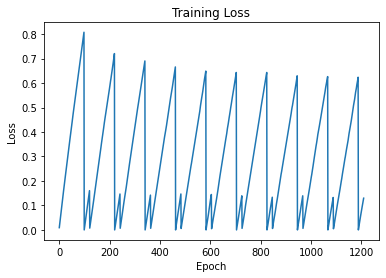

In [9]:
import matplotlib.pyplot as plt
# 训练模型
textloss_list = []
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(text_train_loader, 0):
        # 获取输入数据和标签
        inputs, labels = data['input_ids'], data['labels_id'].long()

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        # 将梯度归零
        optimizer.zero_grad()

        # 前向传递
        outputs = textmodel(inputs)

        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()

        # 更新权重
        optimizer.step()

        # 统计损失值
        running_loss += loss.item()
        
        # 统计准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 每 200 批次打印一次统计信息
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, correct / total))
            running_loss = 0.0
        
        epoch_loss = running_loss / len(text_train_loader)
        textloss_list.append(epoch_loss)
        
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for data in text_test_loader:
#                 inputs, labels = data['input_ids'], data['labels_id'].long()
#                 inputs = inputs.to('cuda')
#                 labels = labels.to('cuda')
#                 outputs = textmodel(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#         test_accuracy = correct / total
#         print('Test accuracy: %.3f' % test_accuracy)
        
# 绘制loss下降图
plt.plot(textloss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()